# Time series classification

In this notebook, we train two neural network models to classify time series. 

The time series, generated with simulated data, are modeled after BCR-ABL load during leukemia therapy, using a bi-exponential decay function. 

Two models are used:
1. LSTM: recurrent neural network model (LSTM = long-short term memory).
2. CNN: 1D convolutional neural network model. 

These models differ in how they process the input data. In the LSTM model, the time series is processes as a sequence in its original order yielding a prediction for each token in the sequence, based on the current token *and* all the previous tokens in the sequence. See this blog post for a quick intro in RNNs and LSTMs: http://colah.github.io/posts/2015-08-Understanding-LSTMs/. In contrast, the CNN model processes the whole sequence at once (as a one-dimensional image) using convolutional operator.

Both model take as same input and output:
- input: time sequence of log(BCR-ABL)
- output: (normalized) probabilities of class 0 ('normal') or class 1 ('relapse')

In both cases, we use the binary crossentropy loss function and RMSProp as optimizer.


# Generate artificial data

Bi-exponential function:

$$y = a_1 e^{-b_1 t} + a_2 e^{-b_2 t}$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

def f(a1, b1, a2, b2, t):
    '''Bi-exponential function'''
    return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2*t)

def f_sigma(a1, sigma):
    '''Bi-exponential function with normal random distributed a1'''
    a1_instance = np.random.normal(loc=a1, scale=sigma)
    return f(a1_instance, b1, a2, b2, t)

/Users/wdeback/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


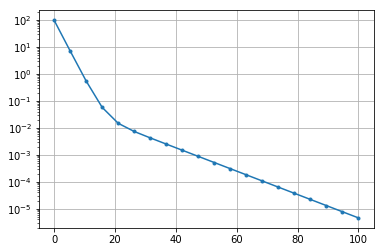

In [2]:
t = np.linspace(0,100.,20.)
a1 = 0.1
b1 = 0.1
a2 = 100.0
b2 = 0.5

plt.semilogy(t, f(a1, b1, a2, b2, t), marker='.')
plt.grid(True)

In [3]:
def generate_dataset(diff_a1, size, sigma):
    '''
    Generate a dataset of time courses.
    
    Args:
    - diff_a1: factor by which the second a1 is multiplied
    - size: number of samples per class
    - sigma: in-group variance
    '''

    x = [] # time courses
    y = [] # labels: relapse? 

    # 'normal'
    for i in range(0,size):
        tc = f_sigma(a1, sigma=sigma)
        x.append(tc)
        y.append(0) # no 'relapse'
        plt.semilogy(t, tc, c='g', alpha=0.1)
        plt.grid(True)

    # 'relapse'
    for i in range(0,size):
        tc = f_sigma(diff_a1*a1, sigma=sigma)
        x.append(tc)
        y.append(1) # 'relapse'
        plt.semilogy(t, tc, c='r', alpha=0.1)
        
    return np.nan_to_num(np.log(np.array(x))), np.array(y) # NOTE: take LOGARITHM

(array([[  4.60616725,   1.9817471 ,  -0.59292365,  -2.85009482,
          -4.21085139,  -4.91007775,  -5.45965552,  -5.98884227,
          -6.51550834,  -7.04186681,  -7.5681878 ,  -8.09450422,
          -8.62082009,  -9.14713589,  -9.67345168, -10.19976747,
         -10.72608326, -11.25239905, -11.77871484, -12.30503063],
        [  4.60543775,   1.97578563,  -0.64011426,  -3.15150446,
          -5.12573233,  -6.15690597,  -6.76660455,  -7.30356949,
          -7.83119027,  -8.35766515,  -8.88400032,  -9.41031847,
          -9.93663454, -10.46295037, -10.98926616, -11.51558195,
         -12.04189774, -12.56821353, -13.09452932, -13.62084511]]),
 array([0, 1]))

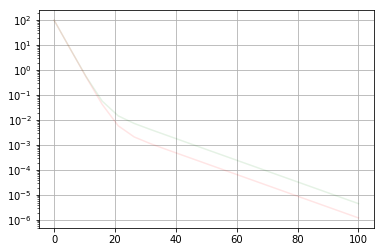

In [4]:
# single sample
generate_dataset(diff_a1=0.25, size=1, sigma=0.001)


**Generate noisy data set**

/Users/wdeback/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
Using TensorFlow backend.


(1000, 2)


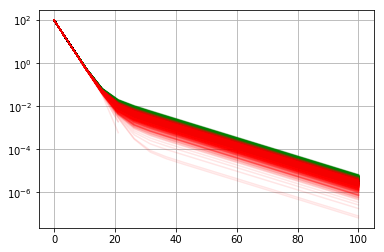

In [5]:
X, y = generate_dataset(diff_a1=0.5, size=500, sigma=0.02)

# add channels dimension
X = np.expand_dims(X, -1)

# convert labels to one-hot format
from keras.utils import to_categorical
y = to_categorical(y)
print(y.shape)


**Split training and validation sets**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [7]:
X_train.shape
#y_train.shape

(750, 20, 1)

# Define models

In [8]:
def LSTM_model(input_length):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.layers import Embedding
    from keras.layers import LSTM

    model = Sequential()
    model.add(LSTM(128, input_shape=(input_length,1)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

    return model

def CNN_model(input_length):
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.layers import Embedding
    from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

    model = Sequential()
    print((input_length, 1))
    model.add(Conv1D(64, 7, activation='relu', input_shape=(input_length, 1), padding='same'))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [9]:
lstm = LSTM_model(input_length=X_train.shape[1])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 74,946
Trainable params: 74,946
Non-trainable params: 0
_________________________________________________________________


In [10]:
cnn = CNN_model(input_length=X_train.shape[1])
cnn.summary()

(20, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20, 64)            512       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 128)            24704     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__

**Helper function to plot loss and accuracy during training**

In [11]:
from IPython.display import clear_output
from keras.callbacks import Callback
class PlotLearning(Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4), sharex=True)
        
        clear_output(wait=True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss", lw=2)
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.set_ylim(bottom=0.)
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy", lw=2)
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.set_ylim(bottom=0., top=1.)
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

# Fit

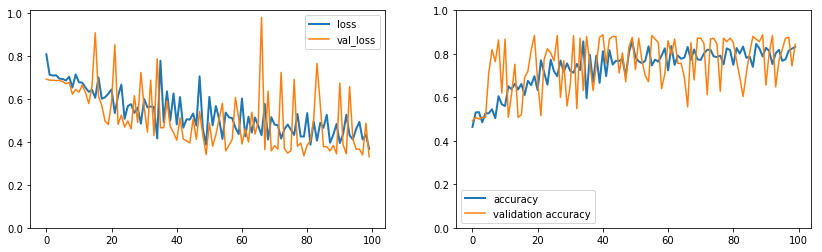

750/750 [==============================] - 1s 1ms/step - loss: 0.3679 - acc: 0.8320 - val_loss: 0.3306 - val_acc: 0.8440
Exec time = 98.6 sec


In [12]:
import time
print ('Fitting LSTM model...')
tic = time.time()
hist = lstm.fit(X_train, y_train, batch_size=128, epochs=100, 
                 validation_data = (X_test, y_test), 
                 verbose = 1, callbacks=[plot])
toc = time.time()
print('Exec time = {:.1f} sec'.format(toc-tic))

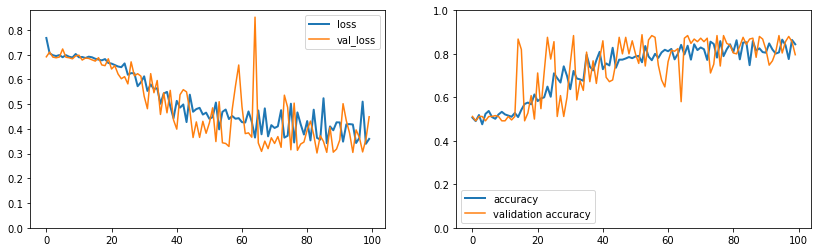

750/750 [==============================] - 1s 800us/step - loss: 0.3596 - acc: 0.8440 - val_loss: 0.4492 - val_acc: 0.7960
Exec time = 47.7 sec


In [13]:
print ('Fitting 1D CNN model...')
tic = time.time()
hist = cnn.fit(X_train, y_train, batch_size=128, epochs=100, 
                 validation_data = (X_test, y_test), 
                 verbose = 1, callbacks=[plot])
toc = time.time()
print('Exec time = {:.1f} sec'.format(toc-tic))

----

# Validate

In [14]:
print('Validate LSTM model...')
val_loss, val_acc = lstm.evaluate(X_test, y_test)
print('Validation accuracy = {:.1f} %'.format(100.0*val_acc))

Validate LSTM model...
250/250 [==============================] - 0s 446us/step
Validation accuracy = 84.4 %


In [15]:
print('Validate CNN model...')
val_loss, val_acc = cnn.evaluate(X_test, y_test)
print('Validation accuracy = {:.1f} %'.format(100.0*val_acc))

Validate CNN model...
250/250 [==============================] - 0s 176us/step
Validation accuracy = 79.6 %


# Predict

Predict with LSTM model...


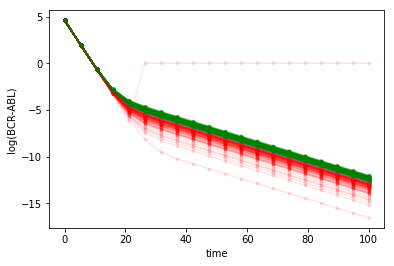

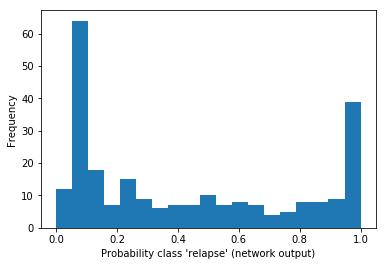

In [16]:
print('Predict with LSTM model...')

probabilities = []
for x in X_test:
    #x = f_sigma(a1, sigma=0.)
    x = np.expand_dims(x,0)  # add batch dim
    #x = np.expand_dims(x,-1) # add channels dim
    #print(x)
    probs = lstm.predict(x, batch_size=1)
    #print(probs)
    #print('{:>10.2f}'.format(probs[0,1]))
    
    p_relapse = probs[0,1]
    color = 'grey'
    if p_relapse > 0.60:
        color = 'red'
    elif p_relapse < 0.40:
        color = 'green'

    probabilities.append( p_relapse )
    #print(np.squeeze(x))
    plt.plot(t, np.squeeze(x), c=color, marker='.', alpha=0.10)
    plt.xlabel('time')
    plt.ylabel('log(BCR-ABL)')

plt.show()

plt.figure()
_ = plt.hist(probabilities, bins=np.linspace(0,1,20))
plt.xlabel("Probability class 'relapse' (network output)")
plt.ylabel("Frequency")

Predict with CNN model...


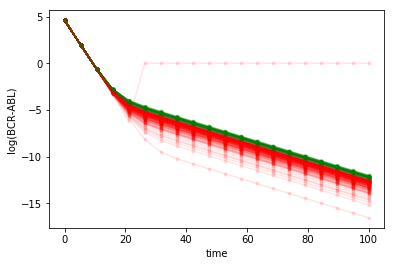

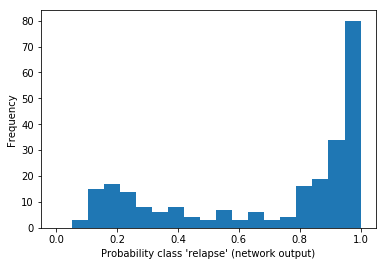

In [17]:
print('Predict with CNN model...')

probabilities = []
for x in X_test:
    #x = f_sigma(a1, sigma=0.)
    x = np.expand_dims(x,0)  # add batch dim
    #x = np.expand_dims(x,-1) # add channels dim
    #print(x)
    probs = cnn.predict(x, batch_size=1)
    #print(probs)
    #print('{:>10.2f}'.format(probs[0,1]))
    
    p_relapse = probs[0,1]
    color = 'grey'
    if p_relapse > 0.60:
        color = 'red'
    elif p_relapse < 0.40:
        color = 'green'

    probabilities.append( p_relapse )
    #print(np.squeeze(x))
    plt.plot(t, np.squeeze(x), c=color, marker='.', alpha=0.10)
    plt.xlabel('time')
    plt.ylabel('log(BCR-ABL)')
    
plt.show()

plt.figure()
_ = plt.hist(probabilities, bins=np.linspace(0,1,20))
plt.xlabel("Probability class 'relapse' (network output)")
plt.ylabel("Frequency")